<h2> LDA - static stopping - expanding

Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 4.9e-05 (2.2e-16 eps * 22 dim * 9.9e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5e-05 (2.2e-16 eps * 22 dim * 1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.3e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5e-05 (2.2e-16 eps * 22 dim * 1e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 co

Choosing from all possible events


Person 7
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.5e-05 (2.2e-16 eps * 22 dim * 7.2e+09  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.7e-05 (2.2e-16 eps * 22 dim * 7.6e+09  max singular value)
    Estimated rank (mag): 22
    MAG: ra

Choosing from all possible events


Person 8
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 6.3e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.8e-05 (2.2e-16 eps * 22 dim * 1.4e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank

Choosing from all possible events


Person 9
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied
Computing rank from data with rank=None


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


    Using tolerance 6.1e-05 (2.2e-16 eps * 22 dim * 1.2e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.3e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e-05 (2.2e-16 eps * 22 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 22
    MAG: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.5e-05 (2.2e-16 eps * 22 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 22
    MAG: ra

Choosing from all possible events


Best params: {'w_step': 175, 'w_length': 232, 'csp_components': 8}
Best accuracy 0.5221126571217315
Classification accuracy: 0.5221126571217315
Subject 3: Accuracy 0.6500362976406533
Subject 9: Accuracy 0.6129461584996976
Subject 8: Accuracy 0.6097035692679975
Subject 7: Accuracy 0.6083484573502722
Subject 1: Accuracy 0.6014337568058077
Subject 4: Accuracy 0.4385480943738657
Subject 2: Accuracy 0.4263883847549909
Subject 6: Accuracy 0.39823956442831215
Subject 5: Accuracy 0.35336963097398677
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
Adding metadata with 3 columns
576 matching events found
No baseline correction applied


/workspaces/UQ_Early_prediction_MI_BCI/.conda/lib/python3.11/site-packages/moabb/paradigms/base.py:354: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  X = mne.concatenate_epochs(X)


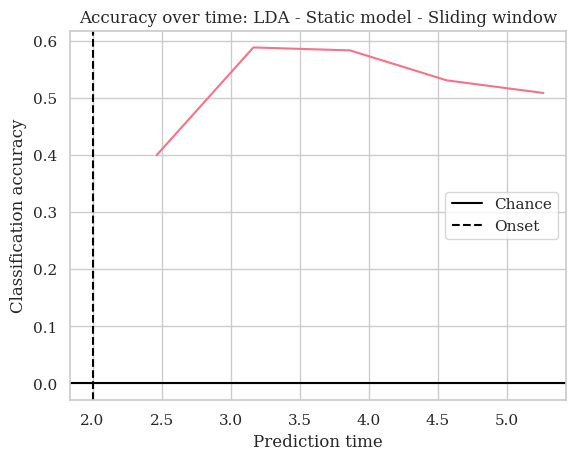

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, KFold
from mne.decoding import CSP

from sklearn.model_selection import ParameterSampler
import numpy as np


current_directory = os.path.abspath('')

project_root = os.path.abspath(os.path.join(current_directory, '..', '..', '..', '..'))

sys.path.append(project_root)

print("ROOT:", project_root)
from Early_predict_UQ.data.make_dataset import make_data


# epoch tmin  = 2 and tmax = 6 , as the motor imagery task lasted in that time
def run_sliding_classification(subjects, w_length, w_step, csp_components):
    scores_across_subjects = []
    current_person = 0
    subjects_accuracies = []
    for person in subjects:
        current_person += 1
        print("Person %d" % (person))
        subject= [person]
        epochs, labels = make_data(subject)
        epochs_train = epochs.copy()
        labels = epochs.events[:, -1] - 4
        epochs_data = epochs.get_data(copy=False)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        scores_cv_splits = []

        lda = LinearDiscriminantAnalysis()
        csp = CSP(n_components= csp_components, reg=None, log=True, norm_trace=False)
        current_cv = 0 
        for train_idx, test_idx in kf.split(epochs_data):
            current_cv += 1
            y_train, y_test = labels[train_idx], labels[test_idx]
            X_train = csp.fit_transform(epochs_data[train_idx], y_train)
            lda.fit(X_train, y_train)

            w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step) 
            scores_across_epochs = []
            for n in w_start:
                X_test_window = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
                score = lda.score(X_test_window, y_test)
                scores_across_epochs.append(score)
            if current_cv == 1:
                scores_cv_splits = np.array(scores_across_epochs)
            else:
                scores_cv_splits = np.vstack((scores_cv_splits,np.array(scores_across_epochs)))

        mean_scores_across_cv = np.mean(scores_cv_splits, axis=0)
        if current_person == 1:
            scores_across_subjects  = np.array(mean_scores_across_cv)
        else:
            scores_across_subjects = np.vstack((scores_across_subjects,np.array(mean_scores_across_cv)))
        subjects_accuracies.append(np.mean(mean_scores_across_cv))
    mean_scores_across_subjects = np.mean(scores_across_subjects, axis=0)
    accuracy = mean_scores_across_subjects

    return subjects_accuracies, accuracy
 
def create_parameterslist(sfreq):
    rng = np.random.RandomState(41)
    
    w_length_values = np.round(rng.uniform(0.1, 1, 10), 2)

    w_step_values = []
    for w_length in w_length_values:
        max_step = max(0.1, 0.99 * w_length)
        w_step = np.round(rng.uniform(0.1, max_step), 1) 
        w_step_values.append(w_step)  
        
    w_length_values = np.round(np.array(w_length_values) * sfreq).astype(int)
    w_step_values = np.round(np.array(w_step_values) * sfreq).astype(int)
    
    parameters = {  
        'csp_components': [2, 4, 6, 8, 10], 
        'w_length': w_length_values, 
        'w_step': w_step_values
    }


    parameters_list = list(ParameterSampler(parameters, n_iter=10, random_state=rng))
    
    return parameters_list



def hyperparameter_tuning (parameters_list, subjects):
    mean_accuracy = 0
    best_accuracy = 0
    for n, param_set in enumerate(parameters_list):
        csp_components = param_set['csp_components']
        w_length = param_set['w_length'] 
        w_step =  param_set['w_step']
        _ , accuracy = run_sliding_classification(subjects, w_length, w_step, csp_components)
        
        mean_accuracy = np.mean(accuracy)

        print(f"Iteration {n+1}/{len(parameters_list)}: Mean accuracy for parameters {param_set} is {mean_accuracy}")

        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_params = param_set

    return best_params, best_accuracy

def evaluate_and_plot(best_params, best_accuracy, accuracy,subjects_accuracies):
    print("Best params:", best_params)
    print("Best accuracy", best_accuracy)
    print("Classification accuracy:", np.mean(accuracy))
    accuracy_array = np.array(accuracy)
    subject_tuples = [(i+1, acc) for i, acc in enumerate(subjects_accuracies)]

    sorted_subjects = sorted(subject_tuples, key=lambda x: x[1], reverse=True)

    for subject, subject_accuracy in sorted_subjects:
        print(f"Subject {subject}: Accuracy {subject_accuracy}")

    labels, tmin = epochs_info(labels=True, tmin=True)

    class_balance = np.zeros(4)
    for i in range(4):
        class_balance[i] = np.mean(labels == i)
    class_balance = np.max(class_balance)

    plt.title("Accuracy over time")
    plt.xlabel("Prediction time")
    plt.ylabel("Classification accuracy")

    prediction_times = np.arange(0, epochs_data.shape[2] - best_params['w_length'], best_params['w_step'])
    prediction_times  = (prediction_times + (best_params['w_length'] / tmin)) / sfreq + tmin

    plt.plot(prediction_times, accuracy_array)
    plt.axhline(class_balance, linestyle="-", color="k", label="Chance")
    plt.axvline(tmin, linestyle="--", color="k", label="Onset")
    plt.title('Accuracy over time: LDA - Static model - Sliding window')
    plt.legend()
    plt.grid(True)
    plt.show()

def epochs_info(labels=False, tmin=False, length=False):
    global epochs_data
    global labels_data
    if labels or tmin or length:
        epochs, labels_data = make_data([1])
        epochs_data = epochs.get_data(copy=False)

    if labels and tmin:
        return labels_data, epochs.tmin
    elif labels and length:
        return labels_data, epochs_data.shape[2]
    elif tmin and length:
        return epochs.tmin, epochs_data.shape[2]
    elif labels:
        return labels_data
    elif tmin:
        return epochs.tmin
    elif length:
        return epochs_data.shape[2]
    else:
        raise ValueError("At least one of 'labels', 'tmin', or 'length' must be True.")


if __name__ == "__main__":
    subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # 9 subjects
    sfreq = 250      
    #Hyperparameter_tuning
    print("\n\n Hyperparameter tuning: \n\n")
    parameters_list = create_parameterslist(sfreq)

    best_params, best_accuracy = hyperparameter_tuning(parameters_list, subjects)
    
    #classify
    print("\n\n Classification: \n\n")
    subjects_accuracies, accuracy = run_sliding_classification(subjects, best_params['w_length'], best_params['w_step'], best_params['csp_components'])
    accuracy_array = np.array(accuracy)

    #evaluate and plot
    evaluate_and_plot(best_params, best_accuracy, accuracy,subjects_accuracies)

